In [6]:
import pandas as pd
import seaborn as sns

# TODO: 15 pixels to mm is just a really rough initial estimate!
def normalize_df(df, window_size, pixel_to_mm=15):
    x0, y0 = df.iloc[0][['x', 'y']] 
    df['X displacement (mm)'] = - (df['x'] - x0) / pixel_to_mm
    df['Y displacement (mm)'] = - (df['y'] - y0) / pixel_to_mm
    
    df['X displacement smoothed (mm)'] = df['X displacement (mm)'].rolling(window=window_size, center=True).mean()
    df['Y displacement smoothed (mm)'] = df['Y displacement (mm)'].rolling(window=window_size, center=True).mean()
    
    df['X displacement smoothed (mm)'] = df['X displacement smoothed (mm)'].fillna(df['X displacement (mm)'])
    df['Y displacement smoothed (mm)'] = df['Y displacement smoothed (mm)'].fillna(df['Y displacement (mm)'])
    
    return df

In [7]:
Y_MIN = 0
Y_MAX = 25
X_MIN = -15
X_MAX = 20
TIME_MAX = 45

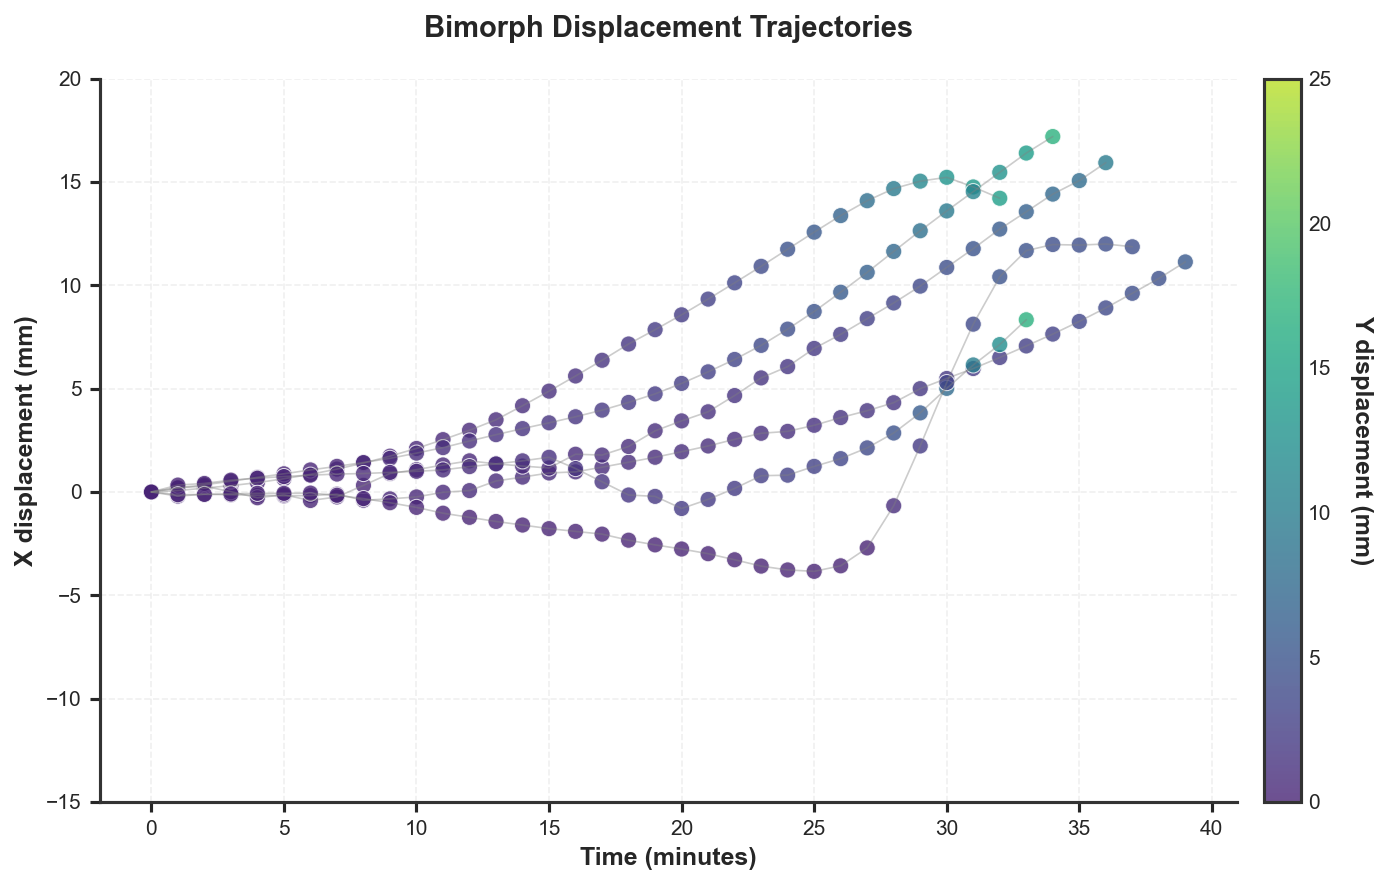

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.cm as cm

# List of file paths for all datasets
file_paths = {
    "experimental_0": ("tracked_trajectories/bimorph_idx0_100x_tracked.csv", (0, 33), 5),
    "experimental_1": ("tracked_trajectories/bimorph_idx1_100x_tracked.csv", (0, None), 5),
    "experimental_2": ("tracked_trajectories/bimorph_idx2_100x_tracked.csv", (0, None), 5),
    "experimental_3": ("tracked_trajectories/bimorph_idx3_100x_tracked.csv", (0, None), 5),
    "experimental_4": ("tracked_trajectories/bimorph_idx4_100x_tracked.csv", (0, None), 5),
    "experimental_5": ("tracked_trajectories/bimorph_idx5_100x_tracked.csv", (0, None), 5),
}

# Set a professional style
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.edgecolor'] = '#333333'

# Load and normalize each DataFrame, adding an experiment_id column
dfs = []
for name, (file, frames, window_size) in file_paths.items():
    df = normalize_df(pd.read_csv(file), window_size=window_size)  # Apply your normalize function
    df["experiment_id"] = name  # Label each dataset
    if frames[1] is not None:
        df = df.iloc[frames[0]:frames[1]]
    else:
        df = df.iloc[frames[0]:]
    dfs.append(df)

# Concatenate all DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Create a custom colormap for Y displacement
custom_cmap = LinearSegmentedColormap.from_list("custom_viridis", 
                                               plt.cm.viridis(np.linspace(0.1, 0.9, 256)))

# Create figure with higher resolution and better proportions
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

# Find the min and max Y values for color normalization
# vmin = #combined_df['Y displacement smoothed (mm)'].min()
# vmax = combined_df['Y displacement smoothed (mm)'].max()
norm = plt.Normalize(Y_MIN, Y_MAX)

# Create a scatter plot for each experiment
for name in combined_df['experiment_id'].unique():
    subset = combined_df[combined_df['experiment_id'] == name]
    
    # Create scatter plot with Y displacement as color
    scatter = ax.scatter(
        subset['minutes'], 
        subset['X displacement smoothed (mm)'],
        c=subset['Y displacement smoothed (mm)'],
        cmap=custom_cmap,
        norm=norm,
        s=60,  # Marker size
        alpha=0.8,  # Slight transparency
        edgecolors='white',  # White outline
        linewidth=0.5,  # Outline width
        label=name
    )

# Add a thin connecting line between points for each experiment (optional)
for name in combined_df['experiment_id'].unique():
    subset = combined_df[combined_df['experiment_id'] == name]
    ax.plot(
        subset['minutes'], 
        subset['X displacement smoothed (mm)'],
        '-',
        linewidth=0.8,
        alpha=0.4,
        color='gray'
    )

# Create a colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label('Y displacement (mm)', rotation=270, labelpad=20, fontsize=12, fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# Customize plot aesthetics
ax.set_xlabel('Time (minutes)', fontsize=12, fontweight='bold')
ax.set_ylabel('X displacement (mm)', fontsize=12, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=10, width=1.5, length=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a legend with custom markers
handles, labels = ax.get_legend_handles_labels()
legend_elements = []
for i, label in enumerate(labels):
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                          label=label, markerfacecolor=plt.cm.tab10(i), 
                          markersize=10))
# ax.legend(handles=legend_elements, title='Experiments', 
#           loc='upper right', frameon=True, fontsize=10)

# Set a better title
plt.title('Bimorph Displacement Trajectories', fontsize=14, fontweight='bold', pad=20)

# Adjust plot limits with some padding
minutes_min, minutes_max = combined_df['minutes'].min(), combined_df['minutes'].max()
ax.set_xlim(minutes_min - 0.05 * (minutes_max - minutes_min), minutes_max + 0.05 * (minutes_max - minutes_min))
ax.set_ylim(X_MIN, X_MAX)

# Add grid but keep it subtle
ax.grid(True, linestyle='--', alpha=0.3)

# Tight layout and save
plt.tight_layout()
plt.savefig('bimorph_displacement_publication.pdf', bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
from scipy.ndimage import gaussian_filter1d


# List of file paths for all datasets
file_paths = {
    "experimental_0": ("tracked_trajectories/bimorph_idx0_100x_tracked.csv", (0, 33), 5),
    "experimental_1": ("tracked_trajectories/bimorph_idx1_100x_tracked.csv", (0, None), 5),
    "experimental_2": ("tracked_trajectories/bimorph_idx2_100x_tracked.csv", (0, None), 5),
    "experimental_3": ("tracked_trajectories/bimorph_idx3_100x_tracked.csv", (0, None), 5),
    "experimental_4": ("tracked_trajectories/bimorph_idx4_100x_tracked.csv", (0, None), 5),
    "experimental_5": ("tracked_trajectories/bimorph_idx5_100x_tracked.csv", (0, None), 5),
}

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.edgecolor'] = '#333333'
mpl.rcParams['grid.alpha'] = 0.3
mpl.rcParams['grid.linestyle'] = '--'

# For visualization purposes only - if you don't have the data files, create synthetic data
# This section would be replaced with your actual data loading in a real scenario
np.random.seed(42)
# X_MIN, X_MAX = 10, 15

# Load and normalize each DataFrame, adding an experiment_id column
dfs = []
for name, (file, frames, window_size) in file_paths.items():
    df = normalize_df(pd.read_csv(file), window_size)
    df["experiment_id"] = name
    if frames[1] is not None:
        df = df.iloc[frames[0]:frames[1]]
    else:
        df = df.iloc[frames[0]:]
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)
import pdb; pdb.set_trace()

# Create figure with high resolution
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

# Set up a nice blue color palette
main_color = '#1f77b4'  # A nice blue
lighter_blue = '#a6cee3'  # Lighter blue for confidence band
lightest_blue = '#d1e5f0'  # Very light blue for outer confidence band

# Sample on a regular grid for smooth mean and confidence bands
unique_experiments = combined_df['experiment_id'].unique()
x_grid = np.linspace(combined_df['minutes'].min(), combined_df['minutes'].max(), 200)

# We'll resample each trajectory to this grid
resampled_y_values = []

# Plot each individual trajectory with low opacity
for exp_id in unique_experiments:
    subset = combined_df[combined_df['experiment_id'] == exp_id]
    x_values = subset['minutes'].values
    y_values = subset['X displacement smoothed (mm)'].values
    
    # Plot raw data with very low opacity
    ax.plot(x_values, y_values, '-', color=main_color, alpha=0.5, linewidth=0.8)
    
    # Resample this trajectory to the common grid for statistics
    try:
        # Interpolate to get values at grid points
        resampled_y = np.interp(x_grid, x_values, y_values)
        # Apply light smoothing
        resampled_y = gaussian_filter1d(resampled_y, sigma=2)
        resampled_y_values.append(resampled_y)
    except:
        # Skip if interpolation fails
        pass

# Convert to numpy array for statistical operations
resampled_array = np.array(resampled_y_values)

# Calculate mean and standard deviation across all resampled trajectories
mean_y = np.mean(resampled_array, axis=0)
std_y = np.std(resampled_array, axis=0)

# Apply final smoothing to the mean curve for aesthetics
mean_y_smooth = gaussian_filter1d(mean_y, sigma=2)

# Plot confidence bands (1 and 2 standard deviations)
ax.fill_between(x_grid, mean_y_smooth - 2*std_y, mean_y_smooth + 2*std_y, 
                color=lightest_blue, alpha=0.7, label='95% Confidence')
ax.fill_between(x_grid, mean_y_smooth - std_y, mean_y_smooth + std_y, 
                color=lighter_blue, alpha=0.7, label='68% Confidence')

# Plot the mean line with higher emphasis
ax.plot(x_grid, mean_y_smooth, '-', color=main_color, linewidth=2.5, 
        label='Mean Trajectory')

# Add markers to the mean line for emphasis
# marker_indices = np.linspace(0, len(x_grid)-1, 10, dtype=int)
# ax.plot(x_grid[marker_indices], mean_y_smooth[marker_indices], 'x', 
#         color='black', markersize=6, markeredgewidth=1.5)

# Set axis labels and title with nice formatting
ax.set_xlabel('Time (minutes)', fontsize=12, fontweight='bold')
ax.set_ylabel('X displacement (mm)', fontsize=12, fontweight='bold')
ax.set_title('Bimorph Displacement Trajectories', fontsize=14, fontweight='bold', pad=15)

# Clean up the plot
ax.tick_params(axis='both', which='major', labelsize=10, width=1, length=4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust plot limits with some padding
minutes_min, minutes_max = combined_df['minutes'].min(), combined_df['minutes'].max()
ax.set_xlim(minutes_min - 0.05 * (minutes_max - minutes_min), minutes_max + 0.05 * (minutes_max - minutes_min))
ax.set_ylim(X_MIN, X_MAX)

# Add a discrete legend
handles, labels = ax.get_legend_handles_labels()
# legend = ax.legend(handles=handles[:3], loc='upper right', frameon=True, 
#                   framealpha=0.9, edgecolor='lightgray')
# legend.get_frame().set_linewidth(0.5)

# Add grid but keep it subtle (controlled via rcParams above)
# ax.grid(True)

ax.grid(True, linestyle='--', alpha=0.6)

# Add watermark or citation if needed
# fig.text(0.5, 0.01, 'Your Lab/Institution', ha='center', fontsize=8, alpha=0.5)

# Ensure tight layout
plt.tight_layout()

# Save with high quality
plt.savefig('bimorph_displacement_gp_style.pdf', bbox_inches='tight', dpi=300)
plt.savefig('bimorph_displacement_gp_style.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


NameError: name 'normalize_df' is not defined

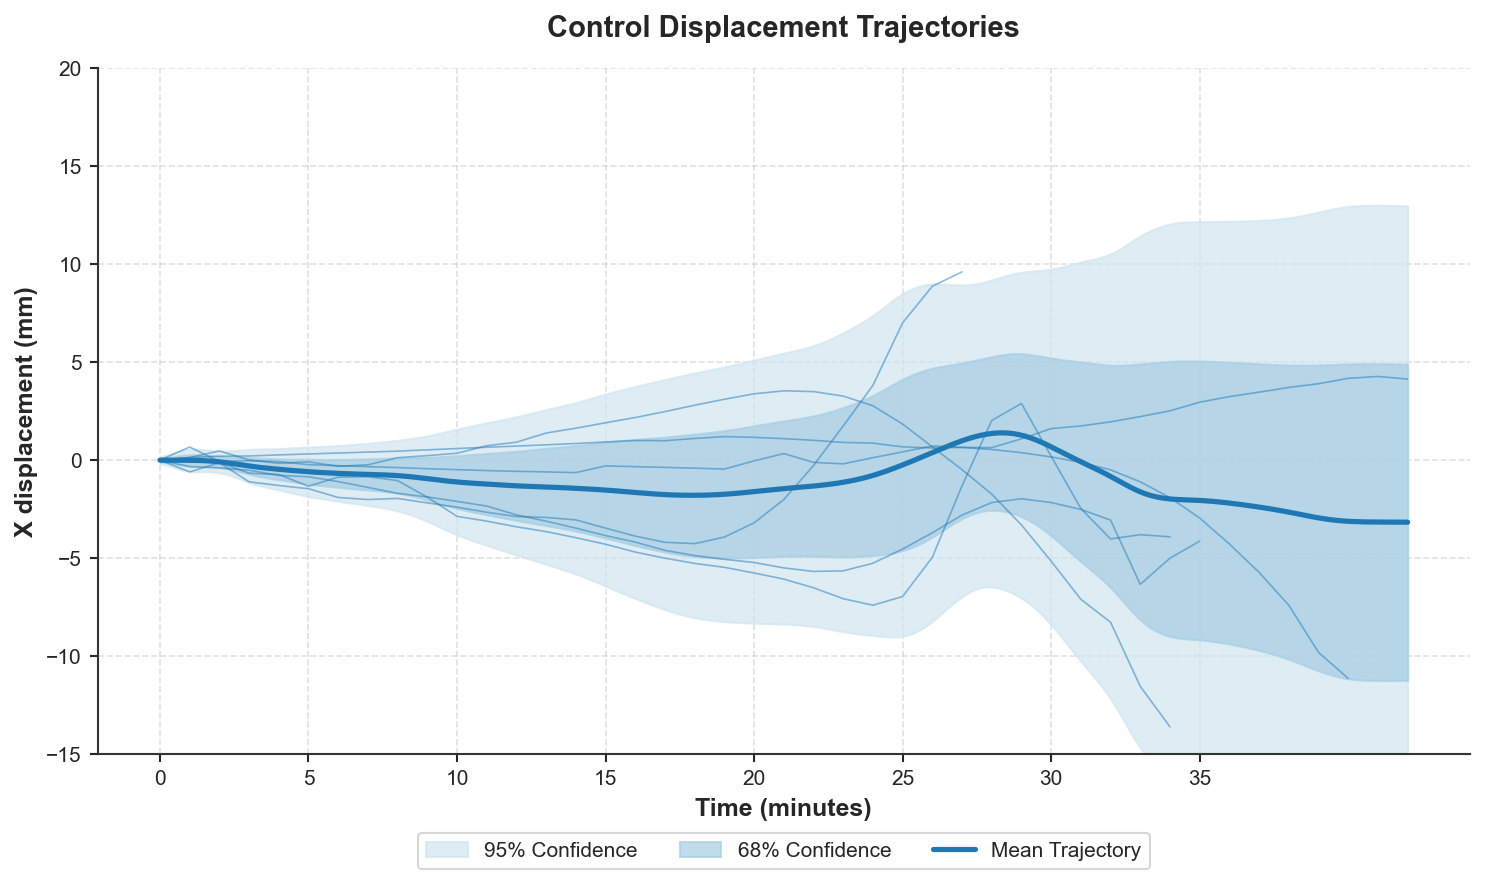

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
from scipy.ndimage import gaussian_filter1d


# List of file paths for all datasets (using the ones from your code)
file_paths = {
    'control_0': ('tracked_trajectories/control_idx0_100x_tracked.csv', (0, 43), 7),
    'control_1': ('tracked_trajectories/control_idx1_100x_tracked.csv', (0, None), 7),
    'control_2': ('tracked_trajectories/control_idx2_100x_tracked.csv',(0, None), 7),
    'control_3': ('tracked_trajectories/control_idx3_100x_tracked.csv', (0, 35), 3), # window=3
    'control_4': ('tracked_trajectories/control_idx4_100x_tracked.csv', (0, None), 7),
    'control_5': ('tracked_trajectories/control_idx5_100x_tracked.csv',(0, 35), 7),
}

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.edgecolor'] = '#333333'
mpl.rcParams['grid.alpha'] = 0.3
mpl.rcParams['grid.linestyle'] = '--'

# For visualization purposes only - if you don't have the data files, create synthetic data
# This section would be replaced with your actual data loading in a real scenario
np.random.seed(42)
# Try to load real data, fall back to synthetic if files not available
try:
    # Load and normalize each DataFrame, adding an experiment_id column
    dfs = []
    for name, (file, frames, window_size) in file_paths.items():
        df = normalize_df(pd.read_csv(file), window_size)
        df["experiment_id"] = name
        if frames[1] is not None:
            df = df.iloc[frames[0]:frames[1]]
        else:
            df = df.iloc[frames[0]:]
        dfs.append(df)
    
    combined_df = pd.concat(dfs, ignore_index=True)
except Exception as e:
    print(f"Using synthetic data due to: {e}")
    # combined_df = create_synthetic_data()

# Create figure with high resolution
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

# Set up a nice blue color palette
main_color = '#1f77b4'  # A nice blue
lighter_blue = '#a6cee3'  # Lighter blue for confidence band
lightest_blue = '#d1e5f0'  # Very light blue for outer confidence band

# Sample on a regular grid for smooth mean and confidence bands
unique_experiments = combined_df['experiment_id'].unique()
x_grid = np.linspace(combined_df['minutes'].min(), combined_df['minutes'].max(), 200)

# We'll resample each trajectory to this grid
resampled_y_values = []

# Plot each individual trajectory with low opacity
for exp_id in unique_experiments:
    subset = combined_df[combined_df['experiment_id'] == exp_id]
    x_values = subset['minutes'].values
    y_values = subset['X displacement smoothed (mm)'].values
    
    # Plot raw data with very low opacity
    ax.plot(x_values, y_values, '-', color=main_color, alpha=0.5, linewidth=0.8)
    
    # Resample this trajectory to the common grid for statistics
    try:
        # Interpolate to get values at grid points
        resampled_y = np.interp(x_grid, x_values, y_values)
        # Apply light smoothing
        resampled_y = gaussian_filter1d(resampled_y, sigma=2)
        resampled_y_values.append(resampled_y)
    except:
        # Skip if interpolation fails
        pass

# Convert to numpy array for statistical operations
resampled_array = np.array(resampled_y_values)

# Calculate mean and standard deviation across all resampled trajectories
mean_y = np.mean(resampled_array, axis=0)
std_y = np.std(resampled_array, axis=0)

# Apply final smoothing to the mean curve for aesthetics
mean_y_smooth = gaussian_filter1d(mean_y, sigma=2)

# Plot confidence bands (1 and 2 standard deviations)
ax.fill_between(x_grid, mean_y_smooth - 2*std_y, mean_y_smooth + 2*std_y, 
                color=lightest_blue, alpha=0.7, label='95% Confidence')
ax.fill_between(x_grid, mean_y_smooth - std_y, mean_y_smooth + std_y, 
                color=lighter_blue, alpha=0.7, label='68% Confidence')

# Plot the mean line with higher emphasis
ax.plot(x_grid, mean_y_smooth, '-', color=main_color, linewidth=2.5, 
        label='Mean Trajectory')
# Set axis labels and title with nice formatting
ax.set_xlabel('Time (minutes)', fontsize=12, fontweight='bold')
ax.set_ylabel('X displacement (mm)', fontsize=12, fontweight='bold')
ax.set_title('Control Displacement Trajectories', fontsize=14, fontweight='bold', pad=15)

# Clean up the plot
ax.tick_params(axis='both', which='major', labelsize=10, width=1, length=4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust plot limits with some padding
minutes_min, minutes_max = combined_df['minutes'].min(), combined_df['minutes'].max()
ax.set_xlim(minutes_min - 0.05 * (minutes_max - minutes_min), minutes_max + 0.05 * (minutes_max - minutes_min))
ax.set_ylim(X_MIN, X_MAX)

handles, labels = ax.get_legend_handles_labels()
# Add legend with handles and labels, display it in a single row
ax.legend(handles=handles, labels=labels, loc='upper center', 
          frameon=True, framealpha=0.9, edgecolor='lightgray', 
          ncol=len(handles), bbox_to_anchor=(0.5, -0.1))

# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=True, 
#           framealpha=0.9, edgecolor='lightgray', ncol=3)

# Add grid but keep it subtle (controlled via rcParams above)
# ax.grid(True)

ax.grid(True, linestyle='--', alpha=0.6)

# Add watermark or citation if needed
# fig.text(0.5, 0.01, 'Your Lab/Institution', ha='center', fontsize=8, alpha=0.5)

x_ticks = np.arange(0, 41, 5)  # Start from minutes_min, step by 5
ax.set_xticks(x_ticks)

# Ensure tight layout
plt.tight_layout()

# Save with high quality
plt.savefig('control_displacement_gp_style.pdf', bbox_inches='tight', dpi=300)
plt.savefig('control_displacement_gp_style.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


[<matplotlib.collections.PolyCollection object at 0x13f16c1c0>, <matplotlib.collections.PolyCollection object at 0x13f16ce80>, <matplotlib.lines.Line2D object at 0x13f16d2d0>] ['95% Confidence', '68% Confidence', 'Mean Trajectory']


RuntimeError: Can not put single artist in more than one figure

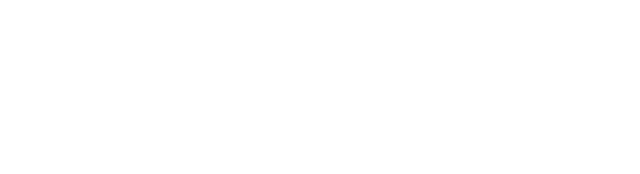

In [31]:
import matplotlib.pyplot as plt

# Example handles and labels (replace with your actual handles and labels)
handles, labels = ax.get_legend_handles_labels()
print(handles, labels)
# Create a new figure
fig, ax = plt.subplots(figsize=(8, 2))  # Small figure to fit the legend row

# Remove axes to focus solely on the legend
ax.axis('off')

# Add legend with handles and labels, display it in a single row
ax.legend(handles=handles, labels=labels, loc='center', 
          frameon=True, framealpha=0.9, edgecolor='lightgray', 
          ncol=len(handles), bbox_to_anchor=(0.5, 0.5))

# Show the plot with the legend in a single row
plt.show()


Handles: [<matplotlib.collections.PolyCollection object at 0x12fa71690>, <matplotlib.collections.PolyCollection object at 0x12fb12bf0>, <matplotlib.lines.Line2D object at 0x13d85c310>], Labels: ['95% Confidence', '68% Confidence', 'Mean Trajectory']
No axes found! You may need to recreate the figure.
Figure: Figure(640x480), Axes: Axes(0.125,0.11;0.775x0.77)
Handles: [], Labels: []


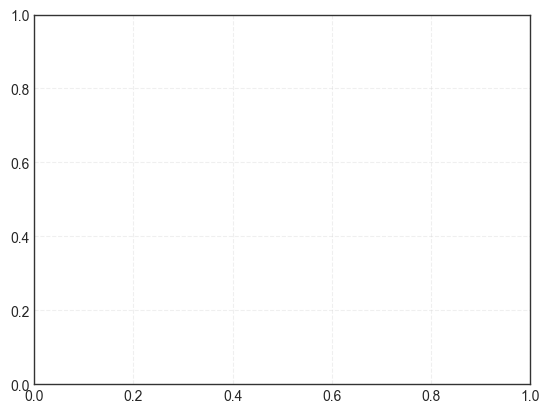

In [ ]:
# Ensure previous legend is removed
if ax.get_legend() is not None:
    ax.get_legend().remove()

# Get handles and labels
# handles, labels = ax.get_legend_handles_labels()
handles, labels = ax.get_legend_handles_labels()
print(f"Handles: {handles}, Labels: {labels}")


# Create a new legend at the bottom
legend = ax.legend(
    handles=handles[:3], loc='lower center', frameon=True,
    framealpha=0.9, edgecolor='lightgray', ncol=len(handles[:3]),  # Put everything in one row
    bbox_to_anchor=(0.5, -0.1)  # Center it below the plot
)
legend.get_frame().set_linewidth(0.5)

# Force update
# plt.draw()
# plt.show()

fig, ax = plt.gcf(), plt.gca()  # Get current figure and axis

print(f"Figure: {fig}, Axes: {ax}")

handles, labels = ax.get_legend_handles_labels()
print(f"Handles: {handles}, Labels: {labels}")  # Debugging
plt.show()


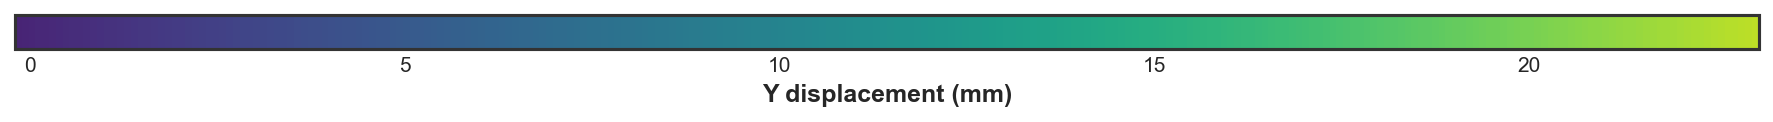

In [99]:
fig_cbar, ax_cbar = plt.subplots(figsize=(15, 0.3), dpi=150)  # Adjust size to be long and narrow
cbar = mpl.colorbar.ColorbarBase(ax_cbar, cmap=custom_cmap, norm=norm, orientation='horizontal')

# Label the colorbar
cbar.set_label('Y displacement (mm)', fontsize=12, fontweight='bold')

# Save and show colorbar separately
plt.savefig('colorbar_figure.pdf', bbox_inches='tight', dpi=300)
plt.show()


<Axes: xlabel='minutes', ylabel='X displacement smoothed (mm)'>

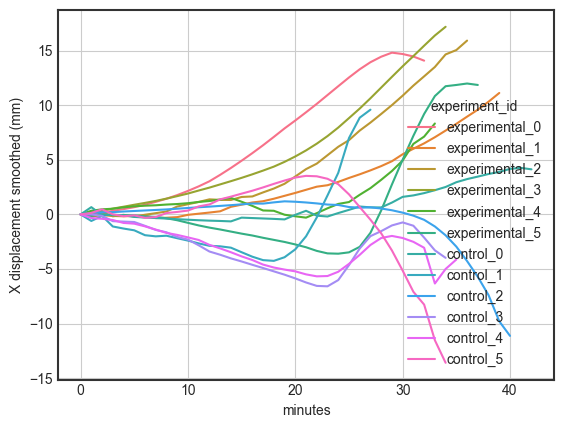

In [78]:
# List of file paths for all datasets
file_paths = {
    "experimental_0": ("tracked_trajectories/bimorph_idx0_100x_tracked.csv", (0, 33)),
    "experimental_1": ("tracked_trajectories/bimorph_idx1_100x_tracked.csv", (0, None)),
    "experimental_2": ("tracked_trajectories/bimorph_idx2_100x_tracked.csv", (0, None)),
    "experimental_3": ("tracked_trajectories/bimorph_idx3_100x_tracked.csv", (0, None)),
    "experimental_4": ("tracked_trajectories/bimorph_idx4_100x_tracked.csv", (0, None)),
    "experimental_5": ("tracked_trajectories/bimorph_idx5_100x_tracked.csv", (0, None)),
    'control_0': ('tracked_trajectories/control_idx0_100x_tracked.csv', (0, 43)),
    'control_1': ('tracked_trajectories/control_idx1_100x_tracked.csv', (0, None)),
    'control_2': ('tracked_trajectories/control_idx2_100x_tracked.csv',(0, None)),
    'control_3': ('tracked_trajectories/control_idx3_100x_tracked.csv', (0, 35)), # window=3
    'control_4': ('tracked_trajectories/control_idx4_100x_tracked.csv', (0, None)),
    'control_5': ('tracked_trajectories/control_idx5_100x_tracked.csv',(0, 35)),
}

# Load and normalize each DataFrame, adding an experiment_id column
dfs = []
for name, (file, frames) in file_paths.items():
    df = normalize_df(pd.read_csv(file))  # Apply your normalize function
    df["experiment_id"] = name  # Label each dataset
    df = df[frames[0]:frames[1]]  
    dfs.append(df)

# Concatenate all DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Plot with seaborn (different lines per experiment)
sns.lineplot(
    data=combined_df, x="minutes", y="X displacement smoothed (mm)", hue="experiment_id"
)